In [690]:
cd ~/data/modl_data/pipeline/contrast/prediction/719/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/719


In [691]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [692]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [693]:
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

pipeline = Pipeline(estimator.steps[:-1])

/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/keras/models.py:150: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [694]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T
intercept = b0

In [695]:
print('Sparsity', (coef == 0).sum() / coef.size)

Sparsity 0.0


In [696]:
pipeline.named_steps['feature_importance'].feature_importance[:] = 1
maps = pipeline.inverse_transform(coef)

mask = fetch_hcp(n_subjects=1).mask
masker = MultiNiftiMasker(mask_img=mask).fit()
imgs = masker.inverse_transform(maps)

print('Shape', imgs.shape)

Shape (91, 109, 91, 53)


In [697]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [698]:
datasets

array(['archi', 'hcp'], dtype=object)

In [699]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [700]:
from sklearn.metrics import confusion_matrix

In [704]:
prediction.loc['train']

predicted_label  \
dataset subject task       contrast             direction                       
archi   1       emotional  expression_control   level1        triangle_random   
                           expression_intention level1     triangle_intention   
                           expression_sex       level1     false_belief_video   
                           face_control         level1        triangle_random   
                           face_sex             level1        triangle_random   
                           face_trusty          level1     triangle_intention   
                localizer  audio                level1             non_speech   
                           calculaudio          level1        triangle_random   
                           calculvideo          level1        triangle_random   
                           clicDaudio           level1             non_speech   
                           clicDvideo           level1             non_speech   
                           clicGaudio           level1             non_speech   
                           clicGvideo           level1             non_speech   
                           computation          level1        triangle_random   
                           damier_H             level1     false_belief_video   
                           damier_V             level1     false_belief_video   
                           motor-cognitive      level1       mecanistic_audio   
                parietal   object_grasp         level1        triangle_random   
                           object_orientation   level1     false_belief_audio   
                           rotation_hand        level1     false_belief_audio   
                           rotation_side        level1     false_belief_audio   
                           saccade              level1       mecanistic_audio   
                social     false_belief_audio   level1             non_speech   
                           false_belief_video   level1        triangle_random   
                           mecanistic_audio     level1       mecanistic_audio   
                           mecanistic_video     level1       mecanistic_audio   
                           non_speech           level1                 speech   
                           speech               level1       mecanistic_audio   
                           triangle_intention   level1       mecanistic_audio   
                           triangle_random      level1       mecanistic_audio   
...                                                                       ...   
hcp     107018  WM         0BK_FACE             level2               0BK_FACE   
                           0BK_PLACE            level2               2BK_BODY   
                           0BK_TOOL             level2               0BK_FACE   
                           2BK_BODY             level2               0BK_FACE   
                           2BK_FACE             level2               0BK_FACE   
                           2BK_PLACE            level2               2BK_BODY   
                           2BK_TOOL             level2               0BK_FACE   
        107321  EMOTION    FACES                level2                  MATCH   
                           SHAPES               level2                  STORY   
                GAMBLING   PUNISH               level2               0BK_FACE   
                           REWARD               level2               0BK_FACE   
                LANGUAGE   MATH                 level2               0BK_BODY   
                           STORY                level2               0BK_TOOL   
                MOTOR      CUE                  level2               0BK_BODY   
                           LF                   level2                  STORY   
                           LH                   level2                 REWARD   
                           RF                   level2                    REL   
            

In [702]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

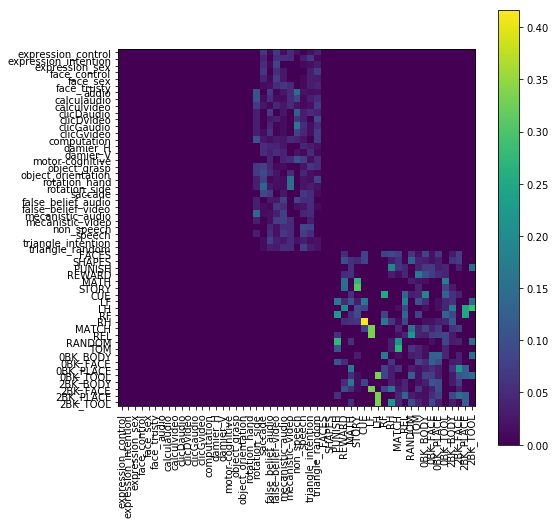

In [703]:
plot_confusion_matrix(train_conf, labels)

In [705]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task        contrast            
archi    emotional   expression_control      0.000000
                     expression_intention    0.000000
                     expression_sex          0.000000
                     face_control            0.000000
                     face_sex                0.000000
                     face_trusty             0.000000
         localizer   audio                   0.000000
                     calculaudio             0.000000
                     calculvideo             0.000000
                     clicDaudio              0.000000
                     clicDvideo              0.000000
                     clicGaudio              0.000000
                     clicGvideo              0.000000
                     computation             0.000000
                     damier_H                0.000000
                     damier_V                0.000000
                     motor-cognitive         0.000000
         parietal    object_grasp       

In [706]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.044444
       hcp        0.086957
train  archi      0.050617
       hcp        0.067633
Name: match, dtype: float64

In [617]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

KeyboardInterrupt: 

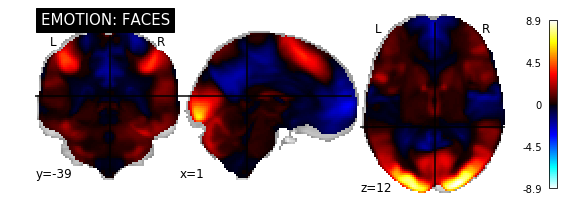

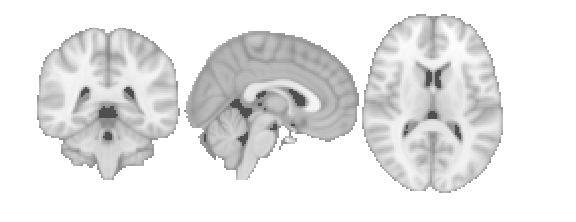

In [618]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [619]:
np.mean(w0 == 0),np.mean(w1 == 0)

(0.0, 0.0)

In [620]:
np.histogram(w1)

(array([   34,   223,  1099,  4358,  8492, 10087,  6574,  2116,   493,   124]),
 array([ -5.41468558e-04,  -4.37985052e-04,  -3.34501546e-04,
         -2.31018040e-04,  -1.27534533e-04,  -2.40510271e-05,
          7.94324791e-05,   1.82915985e-04,   2.86399492e-04,
          3.89882998e-04,   4.93366504e-04]))

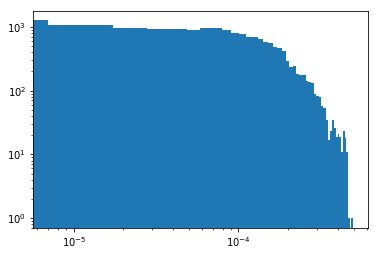

In [623]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)